<a href="https://colab.research.google.com/github/cbalingbing/ePADDY/blob/main/Training_of_Epaddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from tqdm import tqdm

# -------------------
# Preprocessing functions
# -------------------

def split_audio(data, samplerate, segment_duration=10):
    segment_length = segment_duration * samplerate
    num_segments = int(np.ceil(len(data) / segment_length))
    segments = []
    for i in range(num_segments):
        start = int(i * segment_length)
        end = int(min((i + 1) * segment_length, len(data)))
        segment = data[start:end]
        segments.append((segment, i))
    return segments

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist_freq = 0.5 * fs
    low = min(lowcut, highcut) / nyquist_freq
    high = max(lowcut, highcut) / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_butterworth_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def normalize_waveform(data):
    return data / np.max(np.abs(data))

def preprocess_audio(file_path, trim_start=3*60, trim_end=-60,
                     lowcut=93.75, highcut=2500,
                     filter_order=4, segment_duration=10):

    # Load audio
    data, samplerate = sf.read(file_path)

    # Trim
    start_sample = int(trim_start * samplerate)
    end_sample = int(trim_end * samplerate) if trim_end < 0 else int(trim_end * samplerate)
    data = data[start_sample:end_sample]

    # Normalize + Filter
    normalized_data = normalize_waveform(data)
    filtered_data = apply_butterworth_filter(normalized_data, lowcut, highcut, samplerate, filter_order)

    # Split into segments
    return split_audio(filtered_data, samplerate, segment_duration), samplerate

def melspectrogram_from_segment(segment, samplerate, n_mels=128, n_fft=2048, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=samplerate, n_fft=n_fft,
                                              hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Ensure fixed size 128x128
    if mel_spec_db.shape[1] < 128:
        pad_width = 128 - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :128]

    return mel_spec_db

def save_spectrogram(mel_spec_db, save_path):
    plt.figure(figsize=(1.28, 1.28), dpi=100)  # ensures 128x128 output
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.imshow(mel_spec_db, aspect='auto', origin='lower', cmap='magma')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# -------------------
# Dataset builder
# -------------------

def build_dataset(input_root, output_root, max_per_class=6000, train_ratio=0.85, val_ratio=0.10):
    os.makedirs(output_root, exist_ok=True)

    # Gather classes
    class_folders = [f for f in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, f))]

    for class_name in class_folders:
        print(f"\nProcessing class: {class_name}")
        input_class_path = os.path.join(input_root, class_name)

        # Collect all audio files
        audio_files = [os.path.join(input_class_path, f) for f in os.listdir(input_class_path) if f.endswith(".wav")]

        all_segments = []
        for file_path in tqdm(audio_files, desc=f"  {class_name}"):
            try:
                segments, sr = preprocess_audio(file_path)
                for seg, idx in segments:
                    mel = melspectrogram_from_segment(seg, sr)
                    all_segments.append(mel)
            except Exception as e:
                print(f"Error with {file_path}: {e}")

        # Shuffle and trim to max_per_class
        random.shuffle(all_segments)
        all_segments = all_segments[:max_per_class]

        # Split train/val/test
        n_total = len(all_segments)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        train_data = all_segments[:n_train]
        val_data = all_segments[n_train:n_train+n_val]
        test_data = all_segments[n_train+n_val:]

        # Prepare output dirs
        for split in ["train", "valid", "test"]:
            os.makedirs(os.path.join(output_root, class_name, split), exist_ok=True)

        # Save
        for idx, mel in enumerate(train_data):
            save_spectrogram(mel, os.path.join(output_root, class_name, "train", f"{class_name}_train_{idx}.png"))
        for idx, mel in enumerate(val_data):
            save_spectrogram(mel, os.path.join(output_root, class_name, "valid", f"{class_name}_valid_{idx}.png"))
        for idx, mel in enumerate(test_data):
            save_spectrogram(mel, os.path.join(output_root, class_name, "test", f"{class_name}_test_{idx}.png"))

        print(f"  Saved: {len(train_data)} train, {len(val_data)} valid, {len(test_data)} test images for {class_name}")


Exception: Config option jax_dump_ir_to already defined

In [ ]:
subdirectories = [subdir for subdir in os.listdir(OUTPUT_DIR) if os.path.isdir(os.path.join(OUTPUT_DIR, subdir))]

In [ ]:
OUTPUT_DIR ='/content/processed'

In [ ]:
rm -r /content/processed/.ipynb_checkpoints

In [ ]:
OUTPUT_DIR

'/content/processed/'

In [ ]:
X = []
y = []
max_time_steps = 128
OUTPUT_DIR = '/content/processed/'
max_samples_per_class = 5000  # limit per class

for idx, subdir in enumerate(subdirectories):
    subdir_path = os.path.join(OUTPUT_DIR, subdir)

    if subdir.startswith('.'):
        continue

    # Get all wav files
    wav_files = [file for file in os.listdir(subdir_path) if file.endswith('.wav')]

    # If more than max_samples_per_class, undersample randomly
    if len(wav_files) > max_samples_per_class:
        wav_files = random.sample(wav_files, max_samples_per_class)

    for wav_file in wav_files:
        file_path = os.path.join(subdir_path, wav_file)
        spectrogram = load_and_extract_spectrogram(file_path)

        if spectrogram.shape[1] < max_time_steps:
            pad_width = max_time_steps - spectrogram.shape[1]
            spectrogram_padded = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
            X.append(spectrogram_padded)
        else:
            X.append(spectrogram[:, :max_time_steps])  # Trim if spectrogram has more time steps

        y.append(idx)  # Append the index of the current class


In [ ]:
X = np.array(X)
y = np.array(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(subdirectories), activation='softmax')  # Adjust to include the new class
])



model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

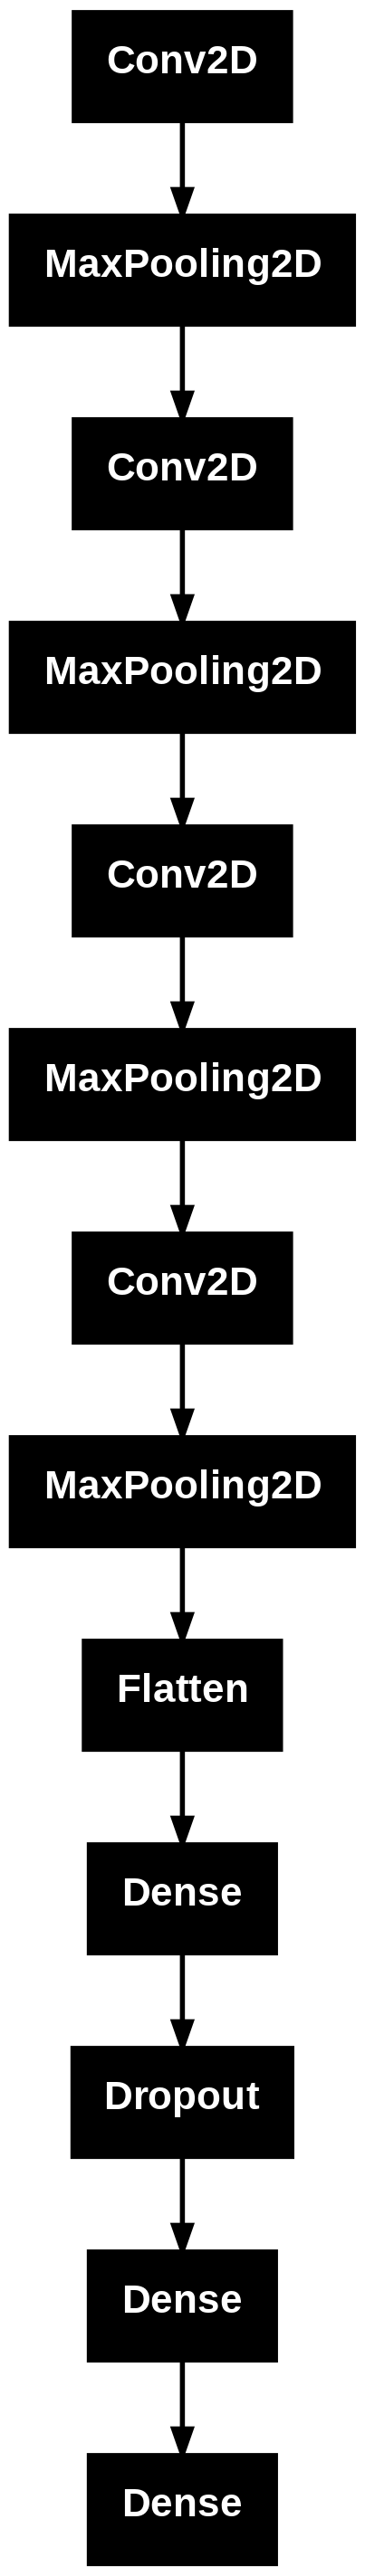

In [ ]:
plot_model(model, to_file='model.png')

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - accuracy: 0.4460 - loss: 1.4482 - val_accuracy: 0.6696 - val_loss: 0.6424
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.7040 - loss: 0.5492 - val_accuracy: 0.7965 - val_loss: 0.4405
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.8038 - loss: 0.4348 - val_accuracy: 0.8635 - val_loss: 0.3144
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.8583 - loss: 0.3203 - val_accuracy: 0.8534 - val_loss: 0.3230
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.8700 - loss: 0.2847 - val_accuracy: 0.8954 - val_loss: 0.2255
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 564s 1s/step - accuracy: 0.8975 - loss: 0.2239 - val_accuracy: 0.8659 - val_loss: 0.3005
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 554s 1s/step - accuracy: 0.8972 - loss: 0.2270 - val_accuracy: 0.8874 - val_loss: 0.2318
Epoch 8/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.9109 - loss: 0.1912 - val_accu

In [ ]:
evaluation_result = model.evaluate(X_test, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 297ms/step - accuracy: 0.9111 - loss: 0.1814
Test Loss: 0.1823030263185501
Test Accuracy: 0.9158034324645996


In [ ]:
def preprocess_audio(file_path, output_folder,
                     trim_start=3*60, trim_end=-60,   # seconds (3 min, last 1 min)
                     lowcut=93.75,  # High-pass cutoff
                     highcut=2500,  # Low-pass cutoff
                     filter_order=4,
                     segment_duration=10):  # seconds

    # Load audio
    data, samplerate = sf.read(file_path)

    # Trim using samples
    start_sample = int(trim_start * samplerate)
    end_sample = int(trim_end * samplerate) if trim_end < 0 else int(trim_end * samplerate)
    data = data[start_sample:end_sample]

    # Normalize waveform
    normalized_data = normalize_waveform(data)

    # Apply band-pass filter
    filtered_data = apply_butterworth_filter(normalized_data, lowcut, highcut, samplerate, filter_order)

    # Save full processed file
    processed_filepath = os.path.join(output_folder, "processed_" + os.path.basename(file_path))
    sf.write(processed_filepath, filtered_data, samplerate)

    # Split into segments
    segments = split_audio(filtered_data, samplerate, segment_duration)
    segment_files = []
    for segment, idx in segments:
        segment_filename = os.path.join(
            output_folder,
            f"processed_segment{idx+1}_" + os.path.basename(file_path)
        )
        sf.write(segment_filename, segment, samplerate)
        segment_files.append(segment_filename)

    return processed_filepath, segment_files

In [ ]:
def load_and_extract_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [ ]:
predict

In [ ]:
# Save the model
model.save('my_model.h5')

In [ ]:
folder_path = ""

# Get list of audio files in the folder
audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

def split_audio(data, samplerate, segment_duration=10):

    segment_length = segment_duration * samplerate
    num_segments = int(np.ceil(len(data) / segment_length))

    segments = []
    for i in range(num_segments):
        start = int(i * segment_length)
        end = int(min((i + 1) * segment_length, len(data)))
        segment = data[start:end]
        segments.append((segment, i))
    return segments

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist_freq = 0.5 * fs
    low = min(lowcut, highcut) / nyquist_freq
    high = max(lowcut, highcut) / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_butterworth_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

# Simple normalization
def normalize_waveform(data):
    return data / np.max(np.abs(data))

def preprocess_audio(file_path, output_folder,
                     trim_start=3*60, trim_end=-60,   # seconds (3 min, last 1 min)
                     lowcut=93.75,  # High-pass cutoff
                     highcut=2500,  # Low-pass cutoff
                     filter_order=4,
                     segment_duration=10):  # seconds

    # Load audio
    data, samplerate = sf.read(file_path)

    # Trim using samples
    start_sample = int(trim_start * samplerate)
    end_sample = int(trim_end * samplerate) if trim_end < 0 else int(trim_end * samplerate)
    data = data[start_sample:end_sample]

    # Normalize waveform
    normalized_data = normalize_waveform(data)

    # Apply band-pass filter
    filtered_data = apply_butterworth_filter(normalized_data, lowcut, highcut, samplerate, filter_order)

    # Save full processed file
    processed_filepath = os.path.join(output_folder, "processed_" + os.path.basename(file_path))
    sf.write(processed_filepath, filtered_data, samplerate)

    # Split into segments
    segments = split_audio(filtered_data, samplerate, segment_duration)
    segment_files = []
    for segment, idx in segments:
        segment_filename = os.path.join(
            output_folder,
            f"processed_segment{idx+1}_" + os.path.basename(file_path)
        )
        sf.write(segment_filename, segment, samplerate)
        segment_files.append(segment_filename)

    return processed_filepath, segment_files

def melspectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    if mel_spec_db.shape[1] < 128:
        pad_width = 128 - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :128]
    return mel_spec_db

for audio_file in audio_files:
    file_path = os.path.join(folder_path, audio_file)

    audio_features = preprocess_audio(file_path)
    audio_features = melspectrogram(audio_features)
    audio_features = np.expand_dims(audio_features, axis=-1)
    audio_features = np.expand_dims(audio_features, axis=0)

    prediction = model.predict(audio_features)[0]

    class_probabilities = {subdir: round(prob * 100, 2) for subdir, prob in zip(subdirectories, prediction)}

    prediction_str = ', '.join([f'{cls}: {prob}%' for cls, prob in class_probabilities.items()])
    print(f"Predictions for {audio_file}: {prediction_str}")





NameError: name 'os' is not defined

In [ ]:
OUTPUT_DIR ='/content/processed'

In [ ]:
files_in_dir = os.listdir(OUTPUT_DIR)
print(files_in_dir)

['RD', 'TC', 'SO', 'NoInsects']


In [ ]:
import os
subdirectories = [subdir for subdir in os.listdir(OUTPUT_DIR) if os.path.isdir(os.path.join(OUTPUT_DIR, subdir))]

For testing the Dataset

In [ ]:
import os
import numpy as np
import soundfile as sf
import librosa
from scipy.signal import butter, filtfilt
from tensorflow.keras.models import load_model

# ========================
# Load your saved model
# ========================
model = load_model("/content/my_model.h5")

# Define your class labels (MUST match training order)
#New subdirectory
#subdirectories = ['RD', 'TC', 'SO', 'NoInsects']

#Old Sub Directory
#subdirectories = ['R_dominica', 'S_oryzae', 'No_insects', 'T_castaneum']

# ========================
# Utility Functions
# ========================
def split_audio(data, samplerate, segment_duration=10):
    segment_length = segment_duration * samplerate
    num_segments = int(np.ceil(len(data) / segment_length))
    segments = []
    for i in range(num_segments):
        start = int(i * segment_length)
        end = int(min((i + 1) * segment_length, len(data)))
        segment = data[start:end]
        segments.append((segment, i))
    return segments

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist_freq = 0.5 * fs
    low = min(lowcut, highcut) / nyquist_freq
    high = max(lowcut, highcut) / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_butterworth_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def normalize_waveform(data):
    return data / np.max(np.abs(data))

def preprocess_audio(file_path, output_folder,
                     trim_start=3*60, trim_end=-60,
                     lowcut=93.75, highcut=2500,
                     filter_order=4, segment_duration=10):

    os.makedirs(output_folder, exist_ok=True)

    # Load audio
    data, samplerate = sf.read(file_path)

    # Trim (start 3 min, remove last 1 min)
    start_sample = int(trim_start * samplerate)
    end_sample = int(trim_end * samplerate) if trim_end < 0 else int(trim_end * samplerate)
    data = data[start_sample:end_sample]

    # Normalize + Filter
    normalized_data = normalize_waveform(data)
    filtered_data = apply_butterworth_filter(normalized_data, lowcut, highcut, samplerate, filter_order)

    # Save full processed file
    processed_filepath = os.path.join(output_folder, "processed_" + os.path.basename(file_path))
    sf.write(processed_filepath, filtered_data, samplerate)

    # Split into segments
    segments = split_audio(filtered_data, samplerate, segment_duration)
    segment_files = []
    for segment, idx in segments:
        segment_filename = os.path.join(output_folder, f"processed_segment{idx+1}_" + os.path.basename(file_path))
        sf.write(segment_filename, segment, samplerate)
        segment_files.append(segment_filename)

    return processed_filepath, segment_files

def melspectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                              hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Ensure fixed width (128 frames)
    if mel_spec_db.shape[1] < 128:
        pad_width = 128 - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :128]

    return mel_spec_db

# ========================
# Prediction Loop
# ========================
folder_path = "/content/drive/MyDrive/redLED"         # your test folder
output_folder = "/content/processed_test"   # processed output

# List of test audio files
audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

for audio_file in audio_files:
    file_path = os.path.join(folder_path, audio_file)

    # Preprocess audio (returns processed file + segments)
    processed_filepath, segment_files = preprocess_audio(file_path, output_folder=output_folder)

    print(f"\nProcessing {audio_file}:")
    for seg_file in segment_files:
        # Convert to Mel spectrogram
        audio_features = melspectrogram(seg_file)

        # Reshape for model (batch, height, width, channel)
        audio_features = np.expand_dims(audio_features, axis=-1)
        audio_features = np.expand_dims(audio_features, axis=0)

        # Predict
        prediction = model.predict(audio_features, verbose=0)[0]

        # Map probabilities
        class_probabilities = {cls: round(prob * 100, 2) for cls, prob in zip(subdirectories, prediction)}

        prediction_str = ', '.join([f'{cls}: {prob}%' for cls, prob in class_probabilities.items()])
        print(f"  Segment {os.path.basename(seg_file)} → {prediction_str}")



Processing redLED_20230616_09h00m05-recording.wav:
  Segment processed_segment1_redLED_20230616_09h00m05-recording.wav → R_dominica: 0.0%, S_oryzae: 99.98999786376953%, No_insects: 0.0%, T_castaneum: 0.0%
  Segment processed_segment2_redLED_20230616_09h00m05-recording.wav → R_dominica: 0.0%, S_oryzae: 99.98999786376953%, No_insects: 0.009999999776482582%, T_castaneum: 0.0%
  Segment processed_segment3_redLED_20230616_09h00m05-recording.wav → R_dominica: 0.0%, S_oryzae: 99.70999908447266%, No_insects: 0.14000000059604645%, T_castaneum: 0.15000000596046448%
  Segment processed_segment4_redLED_20230616_09h00m05-recording.wav → R_dominica: 0.0%, S_oryzae: 99.98999786376953%, No_insects: 0.009999999776482582%, T_castaneum: 0.009999999776482582%
  Segment processed_segment5_redLED_20230616_09h00m05-recording.wav → R_dominica: 0.0%, S_oryzae: 100.0%, No_insects: 0.0%, T_castaneum: 0.0%
  Segment processed_segment6_redLED_20230616_09h00m05-recording.wav → R_dominica: 0.0%, S_oryzae: 0.0099999